In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('grocery_store_data_cleaned.csv', index_col=0)

In [4]:
df.head()

,TICKET,UNITS,REFERENCE,CODE,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,DATE,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT
0,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,1079,1.079000e+03,Pumpkin Japanese/Kent,0.0,1.99,2016-03-16 23:15:39,cash,no ID,Pumpkins,0.000,6.55108,1.99,6.55108
1,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,2032,2.032000e+03,Orange navel,0.0,2.99,2016-03-16 23:15:39,cash,no ID,Citrus,0.000,0.86710,2.99,0.86710
2,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.000,2032,2.032000e+03,Orange navel,0.0,2.99,2016-03-16 23:17:35,cashrefund,NaN,Citrus,-0.000,-2.99000,2.99,-2.99000
3,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,1001,1.001000e+03,Australian Asparagus green,2.0,2.70,2016-03-16 23:19:47,cash,no ID,Bunch Vegies,6.584,8.88840,0.70,2.30440
4,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,4019,8.888101e+12,Nice Munchee 200g,0.9,1.50,2016-03-16 23:19:47,cash,no ID,Sri Lankan Groceries,0.900,1.50000,0.60,0.60000


In [5]:
df.shape

(659221, 15)

# Preprocessing

In [6]:
# Looking at the number of unique values in each column in the dataframe
df.nunique()

TICKET               181970
UNITS                  3437
REFERENCE              1265
CODE                   1265
NAME                   1266
UNIT_PRICEBUY           230
UNIT_PRICESELL          196
DATE                 181969
PAYMENT                   4
TRANSID               32427
CATEGORY                 43
TOTAL_PRICEBUY        10595
TOTAL_PRICESELL       22075
UNIT_PRICE_MARGIN       352
PROFIT                36700
dtype: int64

In [7]:
# Overview of training data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 659221 entries, 0 to 659220
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TICKET             659221 non-null  object 
 1   UNITS              659221 non-null  float64
 2   REFERENCE          659221 non-null  int64  
 3   CODE               659221 non-null  float64
 4   NAME               659221 non-null  object 
 5   UNIT_PRICEBUY      659221 non-null  float64
 6   UNIT_PRICESELL     659221 non-null  float64
 7   DATE               659221 non-null  object 
 8   PAYMENT            659221 non-null  object 
 9   TRANSID            659218 non-null  object 
 10  CATEGORY           659221 non-null  object 
 11  TOTAL_PRICEBUY     659221 non-null  float64
 12  TOTAL_PRICESELL    659221 non-null  float64
 13  UNIT_PRICE_MARGIN  659221 non-null  float64
 14  PROFIT             659221 non-null  float64
dtypes: float64(8), int64(1), object(6)
memory usage: 80

In [8]:
# Check data types
df.dtypes

TICKET                object
UNITS                float64
REFERENCE              int64
CODE                 float64
NAME                  object
UNIT_PRICEBUY        float64
UNIT_PRICESELL       float64
DATE                  object
PAYMENT               object
TRANSID               object
CATEGORY              object
TOTAL_PRICEBUY       float64
TOTAL_PRICESELL      float64
UNIT_PRICE_MARGIN    float64
PROFIT               float64
dtype: object

In [9]:
# Check number of features of each data type
df.dtypes.value_counts()

float64    8
object     6
int64      1
dtype: int64

In [10]:
# Function to check number and percentage of missing values
def missing_values(data):
    total_missing = data.isnull().sum()[data.isnull().sum() != 0]
    percent_missing = round((data.isnull().sum().sort_values()[data.isnull().sum() != 0] / len(data)) * 100, 4)
    return pd.concat([total_missing, percent_missing], axis=1,  keys=['Total Missing Values','Percentage Missing Values'])
# Get missing values for training df
missing_features = missing_values(df)
missing_features

,Total Missing Values,Percentage Missing Values
TRANSID,3,0.0005


In [11]:
# Check for columns having a unique value i.e non-variance in the column
for feature in df.columns:
    if (len(df[feature].unique()) == 1):
        print(feature)

In [12]:
# Convert transaction date to date type
df['TransDate'] = pd.to_datetime(df['DATE'])

In [13]:
# Create a new column for transaction month
df['TransMonth'] = df['TransDate'].dt.month.astype(np.int64)

In [14]:
# Check unique values of transaction months
print('Transaction months:', df['TransDate'].dt.month.astype(np.int64).unique())

Transaction months: [ 3  4  5  6  7  8  9 10 11 12  1  2]


In [15]:
# Check the start and end date
print(df.TransDate.min())
print(df.TransDate.max())

2016-03-16 23:15:39
2019-10-13 17:43:20


In [16]:
# Creating a new dataframe with Date and Ticket as the indices
new_df = df.set_index(['DATE', 'TICKET'])

In [17]:
new_df.head()

UNITS  REFERENCE  \
DATE                TICKET                                                   
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  3.292       1079   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  0.290       2032   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30 -1.000       2032   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  3.292       1001   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  1.000       4019   

                                                                  CODE  \
DATE                TICKET                                               
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  1.079000e+03   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  2.032000e+03   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30  2.032000e+03   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  1.001000e+03   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  8.888101e+12   

                                                                                 NAME  \
DATE                TICKET                                                              
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        Pumpkin Japanese/Kent   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                 Orange navel   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30                 Orange navel   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e   Australian Asparagus green   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            Nice Munchee 200g   

                                                          UNIT_PRICEBUY  \
DATE                TICKET                                                
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30            0.0   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.0   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            0.9   

                                                          UNIT_PRICESELL  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            1.99   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            2.99   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30            2.99   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.70   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            1.50   

                                                             PAYMENT TRANSID  \
DATE                TICKET                                                     
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        cash   no ID   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        cash   no ID   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30  cashrefund     NaN   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e        cash   no ID   
                    aa299de6-1332-48ba-bce9-de8cbb48741e        cash   no ID   

                                                                      CATEGORY  \
DATE                TICKET                                                       
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9              Pumpkins   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                Citrus   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30                Citrus   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e          Bunch Vegies   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  Sri Lankan Groceries   

                                                          TOTAL_PRICEBUY  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d

In [18]:
# Create a new column for transaction year
new_df['TransYear'] = pd.DatetimeIndex(new_df['TransDate']).year

# Data Analysis

In [19]:
new_df2 = df[['CATEGORY', 'NAME']]

In [20]:
new_df2.nunique()

CATEGORY      43
NAME        1266
dtype: int64

In [21]:
new_df3 = new_df2.drop_duplicates(subset='NAME', inplace=False)

In [22]:
# Create a category tree
new_df3.sort_values(by='CATEGORY')

,CATEGORY,NAME
83534,Apples,Golden Delicious 1Kg Punnet
362,Apples,Apples Fuji
104849,Apples,Firm Gold Apple 2kg
104501,Apples,Crimson Snow Apples
13183,Apples,Pink lady kids pack 1kg
...,...,...
32856,trutaste,Raisins 500g
69179,trutaste,Apricot Dried 500g
73938,trutaste,Banana Chips280g
71938,trutaste,Pears 300g


In [23]:
new_df.PAYMENT.unique()

array(['cash', 'cashrefund', 'magcard', 'free'], dtype=object)

In [25]:
# Checking the observations that have a free payment
new_df[new_df['PAYMENT'] == 'free'].head()

UNITS  REFERENCE  \
DATE                TICKET                                                   
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       5004   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  0.682       1017   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       1121   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       4033   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  0.140       1058   

                                                                  CODE  \
DATE                TICKET                                               
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  9.332760e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.017000e+03   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  9.329521e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  9.322670e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.058000e+03   

                                                                         NAME  \
DATE                TICKET                                                      
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  egg free range 600g   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441         Capsicum red   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441          Garlic 500g   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441          Carrots 1kg   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441         Mushroom Cup   

                                                          UNIT_PRICEBUY  \
DATE                TICKET                                                
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441            3.2   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            0.0   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            2.0   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            0.8   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            5.0   

                                                          UNIT_PRICESELL  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441            4.20   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            4.99   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            2.49   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            1.49   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            8.99   

                                                         PAYMENT TRANSID  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   

                                                           CATEGORY  \
DATE                TICKET                                            
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441       Eggs   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441   capsicum   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441     Onions   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    carrots   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  Mushrooms   

                                                          TOTAL_PRICEBUY  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441             3.2   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441             0.0   
                    9c178cbd-5

In [26]:
# Checking the observations that have a cash refund payment
new_df[new_df['PAYMENT'] == 'cashrefund']

,,UNITS,REFERENCE,CODE,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT,TransDate,TransMonth,TransYear
DATE,TICKET,,,,,,,,,,,,,,,,
2016-03-16 23:17:35,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.0,2032,2.032000e+03,Orange navel,0.0,2.99,cashrefund,NaN,Citrus,-0.0,-2.99,2.99,-2.99,2016-03-16 23:17:35,3,2016
2016-07-06 00:30:46,6483004d-f9a5-49ae-9d4c-38f7d5cfef7a,-1.0,6023,9.327530e+12,Mini Toasts Wholemeal 100g,2.0,2.99,cashrefund,NaN,Groceries-Dry Goods,-2.0,-2.99,0.99,-0.99,2016-07-06 00:30:46,7,2016
2016-07-06 00:31:37,aaff8d58-8576-466b-98d1-58fe8652100d,-1.0,6023,9.327530e+12,Mini Toasts Wholemeal 100g,2.0,2.99,cashrefund,NaN,Groceries-Dry Goods,-2.0,-2.99,0.99,-0.99,2016-07-06 00:31:37,7,2016


In [27]:
# Convert Total Price Sell (Revenue) to 0 for free payments
new_df.loc[new_df['PAYMENT'] == 'free', 'TOTAL_PRICESELL'] = 0.00000

In [28]:
# Convert the profit of free payments to losses incured
new_df.loc[new_df['PAYMENT'] == 'free', 'PROFIT'] = -1 * new_df[new_df['PAYMENT'] == 'free']['TOTAL_PRICEBUY']

In [29]:
new_df[new_df['PAYMENT'] == 'free'].head()

UNITS  REFERENCE  \
DATE                TICKET                                                   
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       5004   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  0.682       1017   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       1121   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.000       4033   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  0.140       1058   

                                                                  CODE  \
DATE                TICKET                                               
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  9.332760e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.017000e+03   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  9.329521e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  9.322670e+12   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  1.058000e+03   

                                                                         NAME  \
DATE                TICKET                                                      
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441  egg free range 600g   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441         Capsicum red   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441          Garlic 500g   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441          Carrots 1kg   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441         Mushroom Cup   

                                                          UNIT_PRICEBUY  \
DATE                TICKET                                                
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441            3.2   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            0.0   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            2.0   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            0.8   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            5.0   

                                                          UNIT_PRICESELL  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441            4.20   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            4.99   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            2.49   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            1.49   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441            8.99   

                                                         PAYMENT TRANSID  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    free   no ID   

                                                           CATEGORY  \
DATE                TICKET                                            
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441       Eggs   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441   capsicum   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441     Onions   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441    carrots   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441  Mushrooms   

                                                          TOTAL_PRICEBUY  \
DATE                TICKET                                                 
2016-05-08 01:35:40 9c178cbd-5b82-4981-be92-5e8b26fb1441             3.2   
                    9c178cbd-5b82-4981-be92-5e8b26fb1441             0.0   
                    9c178cbd-5

In [30]:
new_df[new_df['PAYMENT'] == 'cash'].head()

UNITS  REFERENCE  \
DATE                TICKET                                                   
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  3.292       1079   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  0.290       2032   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  3.292       1001   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  1.000       4019   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c  2.230       1001   

                                                                  CODE  \
DATE                TICKET                                               
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  1.079000e+03   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  2.032000e+03   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  1.001000e+03   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  8.888101e+12   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c  1.001000e+03   

                                                                                 NAME  \
DATE                TICKET                                                              
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        Pumpkin Japanese/Kent   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                 Orange navel   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e   Australian Asparagus green   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            Nice Munchee 200g   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c   Australian Asparagus green   

                                                          UNIT_PRICEBUY  \
DATE                TICKET                                                
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.0   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            0.9   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c            2.0   

                                                          UNIT_PRICESELL  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            1.99   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            2.99   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.70   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            1.50   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c            2.70   

                                                         PAYMENT TRANSID  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9    cash   no ID   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9    cash   no ID   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e    cash   no ID   
                    aa299de6-1332-48ba-bce9-de8cbb48741e    cash   no ID   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c    cash   no ID   

                                                                      CATEGORY  \
DATE                TICKET                                                       
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9              Pumpkins   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                Citrus   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e          Bunch Vegies   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  Sri Lankan Groceries   
2016-03-16 23:20:23 fccc4298-a401-414a-98fc-192d4bf9735c          Bunch Vegies   

                                                          TOTAL_PRICEBUY  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e

In [31]:
# Looking at the statistical values of each numerical column
new_df.describe()

,UNITS,REFERENCE,CODE,UNIT_PRICEBUY,UNIT_PRICESELL,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT,TransMonth,TransYear
count,659221.000000,659221.000000,6.592210e+05,659221.000000,659221.000000,659221.000000,659221.000000,659221.000000,659221.000000,659221.000000,659221.000000
mean,0.904336,2133.543411,3.825417e+13,1.115888,3.972506,0.999700,2.886424,2.856619,1.886724,6.432383,2017.422350
std,0.754793,1913.365823,8.425327e+14,1.981139,3.093692,1.841089,2.602306,3.105991,2.138040,3.333835,1.053604
min,-1.000000,1001.000000,1.001000e+03,0.000000,0.000000,-2.000000,-2.990000,-20.000000,-22.837500,1.000000,2016.000000
25%,0.454000,1067.000000,1.067000e+03,0.000000,2.000000,0.000000,1.500000,0.990000,0.700000,4.000000,2017.000000
50%,1.000000,1205.000000,1.256000e+03,0.000000,2.990000,0.000000,2.315360,2.000000,1.420000,6.000000,2017.000000
75%,1.000000,2059.000000,2.070000e+03,2.000000,4.900000,1.576000,3.500000,3.500000,2.500000,9.000000,2018.000000
max,48.000000,9998.000000,9.188933e+16,45.000000,53.000000,138.000000,230.000000,25.000000,215.000000,12.000000,2019.000000


In [32]:
# These are loss making products
new_df[(new_df.UNIT_PRICE_MARGIN < 0)]['NAME'].unique()

array(['Longans ', 'Banana Cavendish', 'Pear Nashi', 'bitter melon',
       'Cabbage Wombok', 'Avocado Hass Medium', 'Vinegar 350ml',
       'Piel de Sapo Melon', 'Red Nashi Pear', 'Hairy Melon',
       'Apple Granny Smith 1kg bag', 'Salad Mix 100g',
       'Baby Spinach 100g', 'grapes Calmeria', 'Cocktail Tomatoes',
       'choy sum 2 for $ 1.99', 'cherry Truss tomato', 'Turmeric',
       'Gold Nugget700g', 'Red Radish bunch', ' Artichoke 2 For 3',
       'Purple Dutch Carrots', 'Brown Onion 1Kg', 'Lemon 1kg'],
      dtype=object)

In [33]:
new_df[new_df.UNIT_PRICEBUY == 45]['NAME'].unique()

array(['Turmeric'], dtype=object)

In [34]:
# Create a new feature, 'seasons'
conditions = [(new_df['TransMonth'] == 1) | (new_df['TransMonth'] == 2) | (new_df['TransMonth'] == 12),
              (new_df['TransMonth'] == 3) | (new_df['TransMonth'] == 4) | (new_df['TransMonth'] == 5),
             (new_df['TransMonth'] == 6) | (new_df['TransMonth'] == 7) | (new_df['TransMonth'] == 8),
             (new_df['TransMonth'] == 9) | (new_df['TransMonth'] == 10) | (new_df['TransMonth'] == 11)]
choices = ['summer', 'fall', 'winter', 'spring']
new_df['season'] = np.select(conditions, choices)

In [35]:
new_df.head()

UNITS  REFERENCE  \
DATE                TICKET                                                   
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  3.292       1079   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  0.290       2032   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30 -1.000       2032   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  3.292       1001   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  1.000       4019   

                                                                  CODE  \
DATE                TICKET                                               
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  1.079000e+03   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9  2.032000e+03   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30  2.032000e+03   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e  1.001000e+03   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  8.888101e+12   

                                                                                 NAME  \
DATE                TICKET                                                              
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        Pumpkin Japanese/Kent   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                 Orange navel   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30                 Orange navel   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e   Australian Asparagus green   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            Nice Munchee 200g   

                                                          UNIT_PRICEBUY  \
DATE                TICKET                                                
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            0.0   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30            0.0   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.0   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            0.9   

                                                          UNIT_PRICESELL  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            1.99   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9            2.99   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30            2.99   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e            2.70   
                    aa299de6-1332-48ba-bce9-de8cbb48741e            1.50   

                                                             PAYMENT TRANSID  \
DATE                TICKET                                                     
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        cash   no ID   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9        cash   no ID   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30  cashrefund     NaN   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e        cash   no ID   
                    aa299de6-1332-48ba-bce9-de8cbb48741e        cash   no ID   

                                                                      CATEGORY  \
DATE                TICKET                                                       
2016-03-16 23:15:39 d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9              Pumpkins   
                    d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9                Citrus   
2016-03-16 23:17:35 f4dd518d-1fd8-4339-abc6-2c5390c20e30                Citrus   
2016-03-16 23:19:47 aa299de6-1332-48ba-bce9-de8cbb48741e          Bunch Vegies   
                    aa299de6-1332-48ba-bce9-de8cbb48741e  Sri Lankan Groceries   

                                                          TOTAL_PRICEBUY  \
DATE                TICKET                                                 
2016-03-16 23:15:39 d

In [36]:
new_df_resetindex = new_df.reset_index()

In [37]:
new_df_resetindex.head()

,DATE,TICKET,UNITS,REFERENCE,CODE,NAME,UNIT_PRICEBUY,UNIT_PRICESELL,PAYMENT,TRANSID,CATEGORY,TOTAL_PRICEBUY,TOTAL_PRICESELL,UNIT_PRICE_MARGIN,PROFIT,TransDate,TransMonth,TransYear,season
0,2016-03-16 23:15:39,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,3.292,1079,1.079000e+03,Pumpkin Japanese/Kent,0.0,1.99,cash,no ID,Pumpkins,0.000,6.55108,1.99,6.55108,2016-03-16 23:15:39,3,2016,fall
1,2016-03-16 23:15:39,d9ea23a9-8a1b-41b4-b554-2bf7e96ca2d9,0.290,2032,2.032000e+03,Orange navel,0.0,2.99,cash,no ID,Citrus,0.000,0.86710,2.99,0.86710,2016-03-16 23:15:39,3,2016,fall
2,2016-03-16 23:17:35,f4dd518d-1fd8-4339-abc6-2c5390c20e30,-1.000,2032,2.032000e+03,Orange navel,0.0,2.99,cashrefund,NaN,Citrus,-0.000,-2.99000,2.99,-2.99000,2016-03-16 23:17:35,3,2016,fall
3,2016-03-16 23:19:47,aa299de6-1332-48ba-bce9-de8cbb48741e,3.292,1001,1.001000e+03,Australian Asparagus green,2.0,2.70,cash,no ID,Bunch Vegies,6.584,8.88840,0.70,2.30440,2016-03-16 23:19:47,3,2016,fall
4,2016-03-16 23:19:47,aa299de6-1332-48ba-bce9-de8cbb48741e,1.000,4019,8.888101e+12,Nice Munchee 200g,0.9,1.50,cash,no ID,Sri Lankan Groceries,0.900,1.50000,0.60,0.60000,2016-03-16 23:19:47,3,2016,fall


In [38]:
new_df_resetindex.groupby('TransDate')['PROFIT'].sum()

TransDate
2016-03-16 23:15:39     7.418180
2016-03-16 23:17:35    -2.990000
2016-03-16 23:19:47     2.904400
2016-03-16 23:20:23     1.561000
2016-03-16 23:29:36    10.490909
                         ...    
2019-10-13 16:39:18     4.829387
2019-10-13 17:02:28     8.297940
2019-10-13 17:31:32     1.409780
2019-10-13 17:41:45    20.596460
2019-10-13 17:43:20     1.760180
Name: PROFIT, Length: 181969, dtype: float64

# Time Series Analysis

In [39]:
#Create a new dataframe
tsinput = new_df_resetindex[['TransDate','TOTAL_PRICESELL']]

In [40]:
tsinput.head()

,TransDate,TOTAL_PRICESELL
0,2016-03-16 23:15:39,6.55108
1,2016-03-16 23:15:39,0.86710
2,2016-03-16 23:17:35,-2.99000
3,2016-03-16 23:19:47,8.88840
4,2016-03-16 23:19:47,1.50000


In [41]:
# Converting the dataframe into datetime format
tsinput['TransDate'] = tsinput['TransDate'].dt.date

In [42]:
# Renaming the columns to send it as an input to the FB Prophet model
tsinput = tsinput.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})

In [43]:
# Aggregating the data with respect to the dates
tsinput1 = pd.DataFrame(tsinput.groupby('ds').sum()).reset_index()

In [44]:
# Creating a basic model and fitting the input to it
prophet_basic = Prophet()
prophet_basic.fit(tsinput1)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [45]:
# Getting the 93 future dates
future = prophet_basic.make_future_dataframe(periods=93)

In [46]:
# Forecasting the values on the basis of the dates that have been given
forecast = prophet_basic.predict(future)

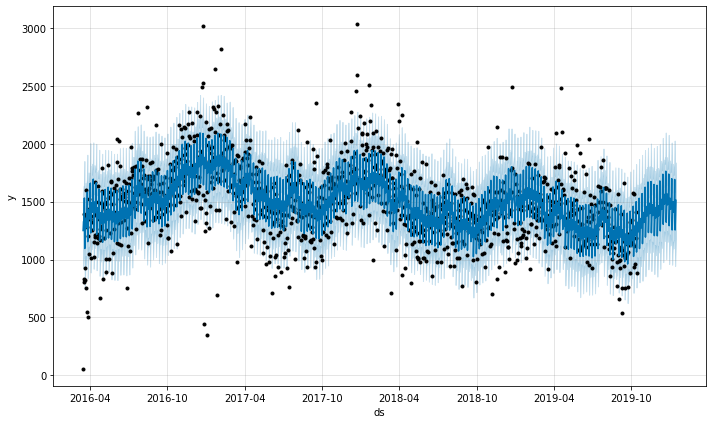

In [47]:
# Plotting the future values
fig1 = prophet_basic.plot(forecast)

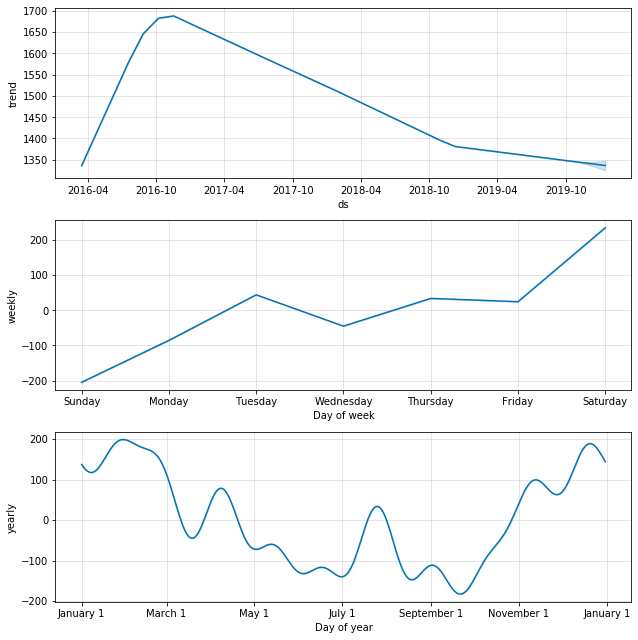

In [48]:
# Plotting the data with respect to dates, day of the week and day of the year
fig1 = prophet_basic.plot_components(forecast)

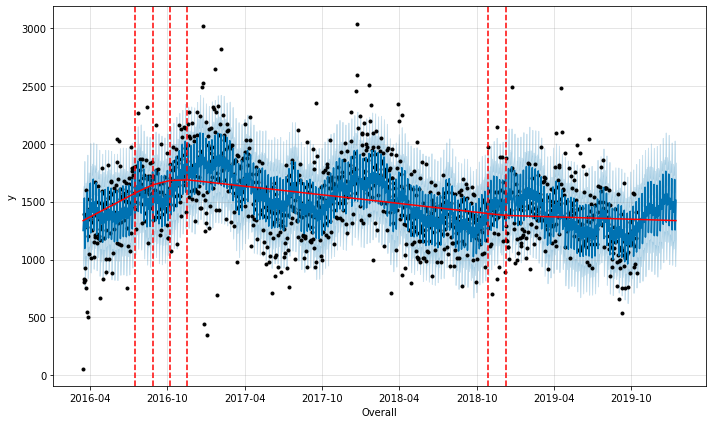

In [49]:
# Plotting a graph for the different checkpoints
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Overall');
plt.savefig('Overall.png')

In [50]:
# Looking at the checkpoints for the entire store
overall_cp = prophet_basic.changepoints

## Time Series for each category

### 1.) Bananas

In [51]:
tsinput_BA = new_df_resetindex[new_df_resetindex.CATEGORY == 'Bananas']
tsinput_BA = tsinput_BA[['TransDate','TOTAL_PRICESELL']]
tsinput_BA['TransDate'] = tsinput_BA['TransDate'].dt.date
tsinput_BA = tsinput_BA.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_BA1 = pd.DataFrame(tsinput_BA.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [52]:
# Creating train and validation data to check for the error rate
train = tsinput_BA1[:1201]
validate = tsinput_BA1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-78:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-78:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 20.548163822415813
The mean absolute error is: 16.993721754608504


##### Predicting the values for the days after the validation data

In [53]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_BA1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


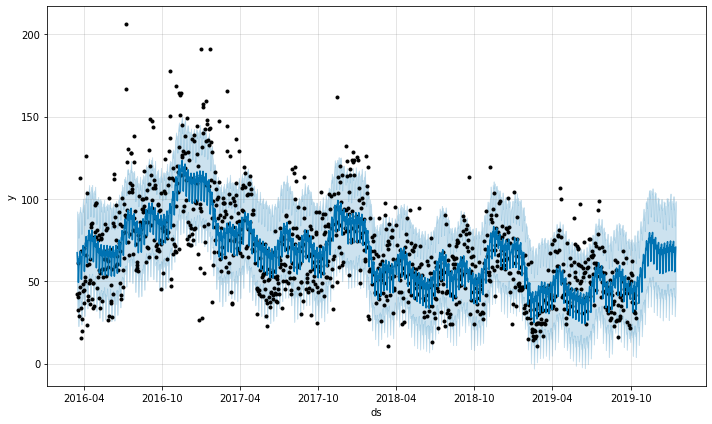

In [54]:
fig1 = prophet_basic.plot(forecast)

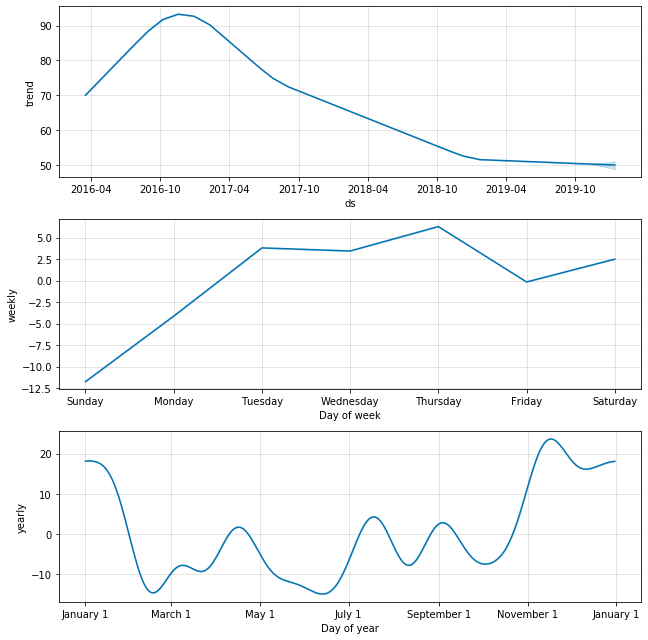

In [55]:
fig1 = prophet_basic.plot_components(forecast)

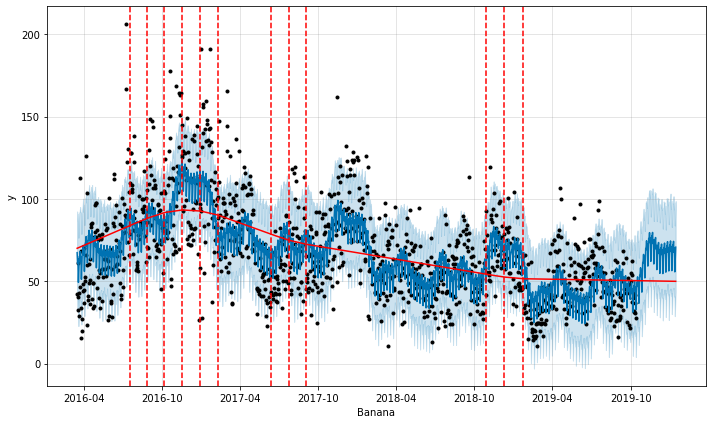

In [56]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Banana');
plt.savefig('Banana.png')

In [57]:
ba_checkpoint = prophet_basic.changepoints

### 2.) Apples

In [58]:
tsinput_AP = new_df_resetindex[new_df_resetindex.CATEGORY == 'Apples']
tsinput_AP = tsinput_AP[['TransDate','TOTAL_PRICESELL']]
tsinput_AP['TransDate'] = tsinput_AP['TransDate'].dt.date
tsinput_AP = tsinput_AP.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_AP1 = pd.DataFrame(tsinput_AP.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [59]:
# Creating train and validation data to check for the error rate
train = tsinput_AP1[:1201]
validate = tsinput_AP1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-78:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-78:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 27.947305233745023
The mean absolute error is: 23.08109480126962


##### Predicting the values for the days after the validation data

In [60]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_AP1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


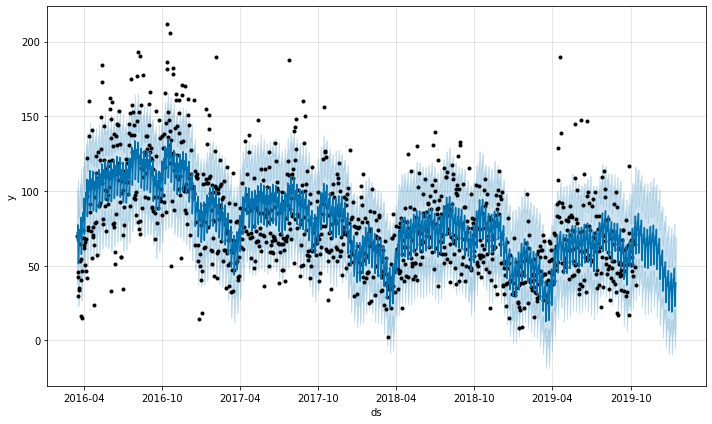

In [61]:
fig1 = prophet_basic.plot(forecast)

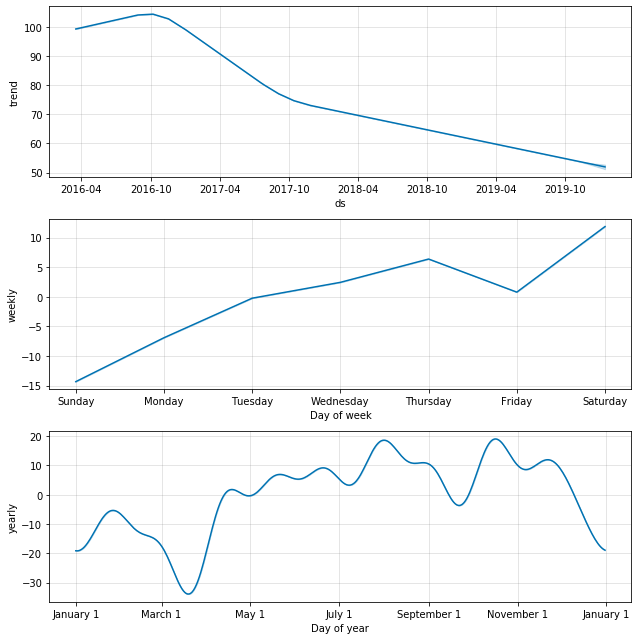

In [62]:
fig1 = prophet_basic.plot_components(forecast)

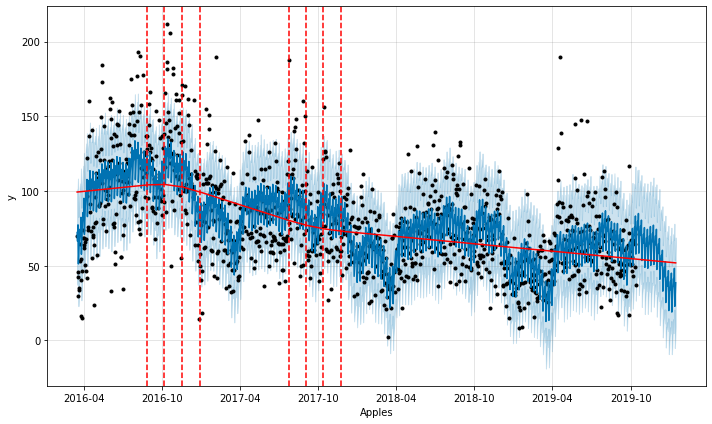

In [63]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Apples');
plt.savefig('Apples.png')

In [64]:
ap_checkpoint = prophet_basic.changepoints

### 3.) Potatoes

In [65]:
tsinput_PO = new_df_resetindex[new_df_resetindex.CATEGORY == 'Potatoes']
tsinput_PO = tsinput_PO[['TransDate','TOTAL_PRICESELL']]
tsinput_PO['TransDate'] = tsinput_PO['TransDate'].dt.date
tsinput_PO = tsinput_PO.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_PO1 = pd.DataFrame(tsinput_PO.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [66]:
# Creating train and validation data to check for the error rate
train = tsinput_PO1[:1201]
validate = tsinput_PO1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-78:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-78:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 30.719972451492232
The mean absolute error is: 24.08254984164611


##### Predicting the values for the days after the validation data

In [67]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_PO1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


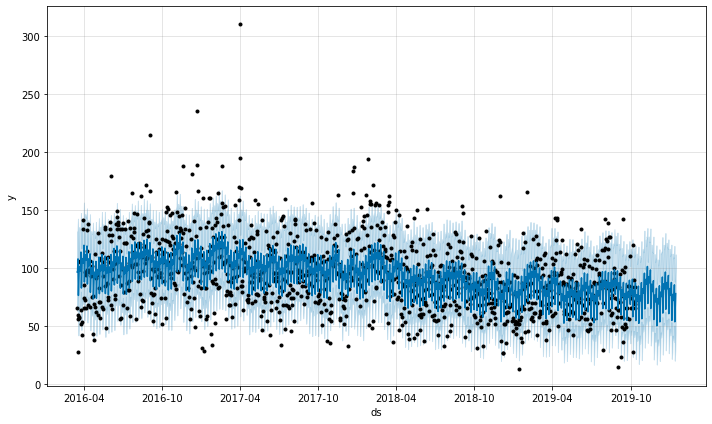

In [68]:
fig1 = prophet_basic.plot(forecast)

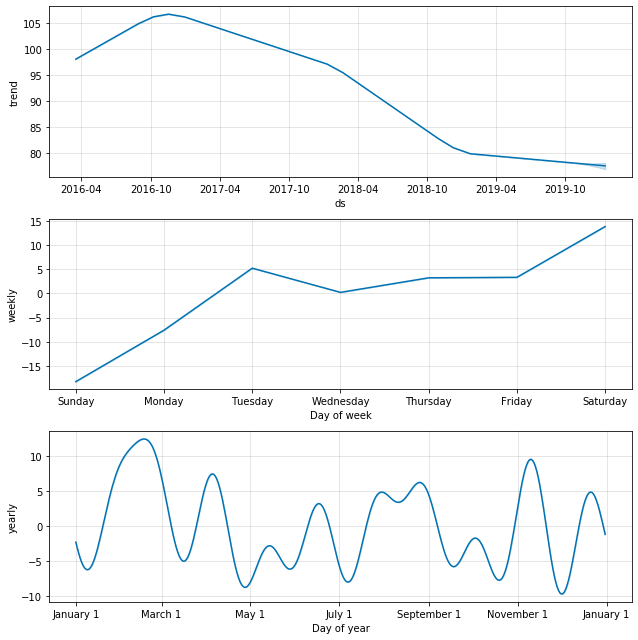

In [69]:
fig1 = prophet_basic.plot_components(forecast)

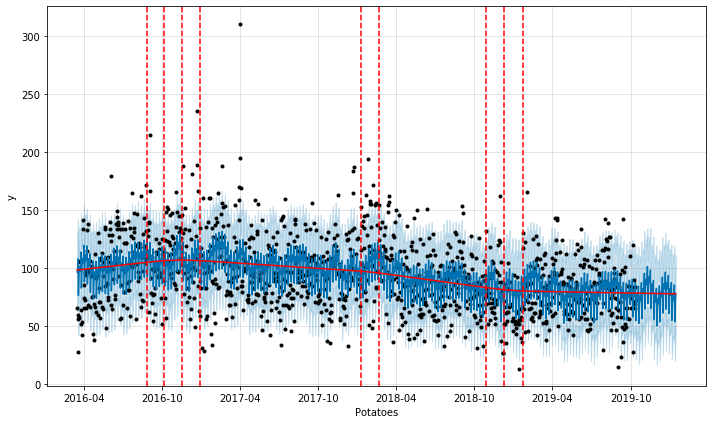

In [70]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Potatoes');
plt.savefig('Potatoes.png')

In [71]:
po_checkpoint = prophet_basic.changepoints

### 4.) Citrus

In [72]:
tsinput_CI = new_df_resetindex[new_df_resetindex.CATEGORY == 'Citrus']
tsinput_CI = tsinput_CI[['TransDate','TOTAL_PRICESELL']]
tsinput_CI['TransDate'] = tsinput_CI['TransDate'].dt.date
tsinput_CI = tsinput_CI.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_CI1 = pd.DataFrame(tsinput_CI.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [73]:
# Creating train and validation data to check for the error rate
train = tsinput_CI1[:1201]
validate = tsinput_CI1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-79:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-79:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 25.636834845541163
The mean absolute error is: 21.295504515410318


##### Predicting the values for the days after the validation data

In [74]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_CI1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


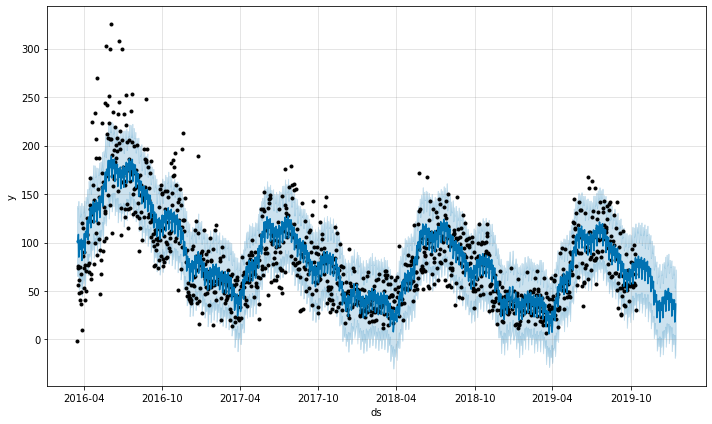

In [75]:
fig1 = prophet_basic.plot(forecast)

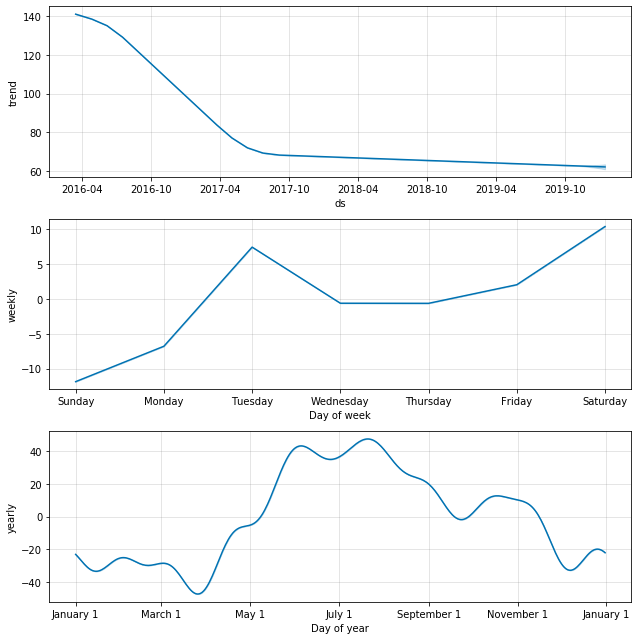

In [76]:
fig1 = prophet_basic.plot_components(forecast)

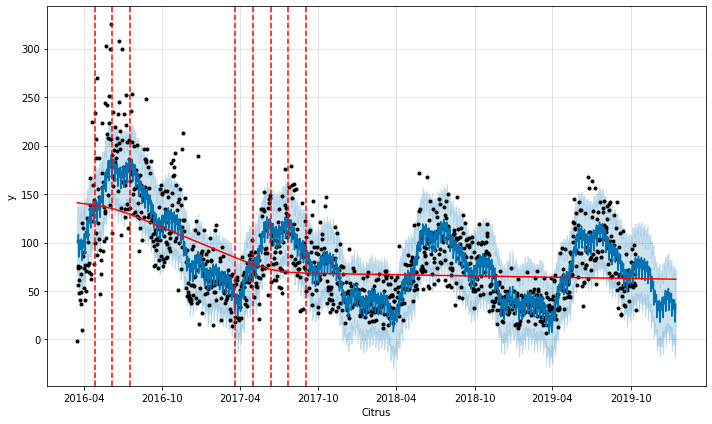

In [77]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Citrus');
plt.savefig('Citrus.png')

In [78]:
ci_checkpoint = prophet_basic.changepoints

### 5.) Tomatoes

In [79]:
tsinput_TO = new_df_resetindex[new_df_resetindex.CATEGORY == 'Tomatoes']
tsinput_TO = tsinput_TO[['TransDate','TOTAL_PRICESELL']]
tsinput_TO['TransDate'] = tsinput_TO['TransDate'].dt.date
tsinput_TO = tsinput_TO.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_TO1 = pd.DataFrame(tsinput_TO.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [80]:
# Creating train and validation data to check for the error rate
train = tsinput_TO1[:1201]
validate = tsinput_TO1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-78:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-78:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 18.023382522991028
The mean absolute error is: 15.120592016665919


##### Predicting the values for the days after the validation data

In [81]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_TO1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


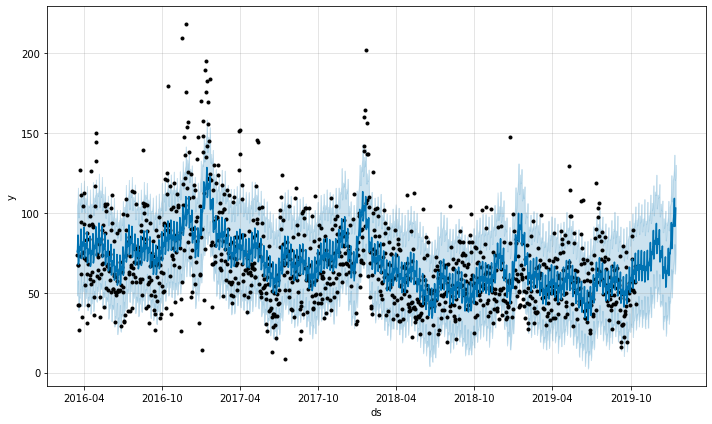

In [82]:
fig1 = prophet_basic.plot(forecast)

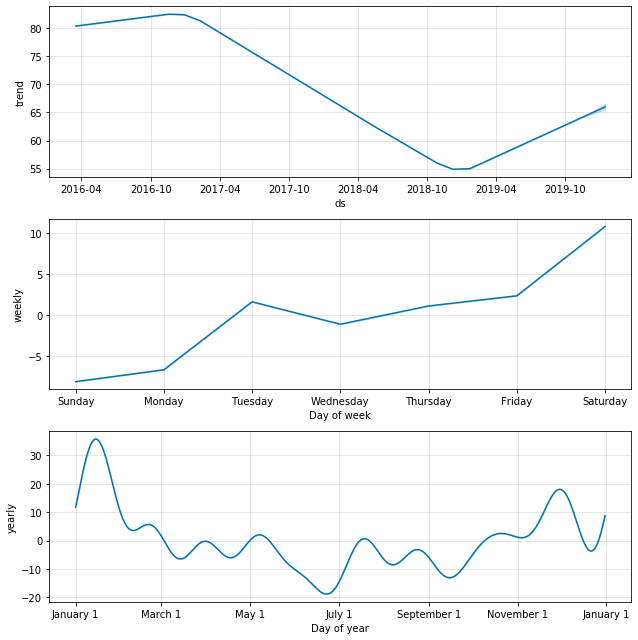

In [83]:
fig1 = prophet_basic.plot_components(forecast)

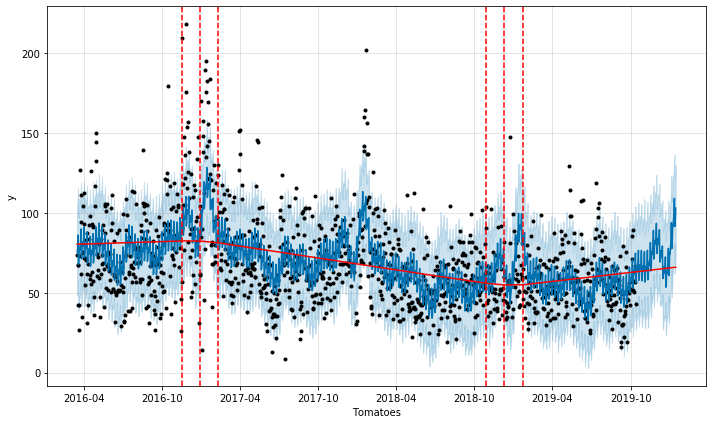

In [84]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Tomatoes');
plt.savefig('Tomatoes.png')

In [85]:
to_checkpoint = prophet_basic.changepoints

### 6.) Other Vegies

In [86]:
tsinput_OV = new_df_resetindex[new_df_resetindex.CATEGORY == 'Other Vegies']
tsinput_OV = tsinput_OV[['TransDate','TOTAL_PRICESELL']]
tsinput_OV['TransDate'] = tsinput_OV['TransDate'].dt.date
tsinput_OV = tsinput_OV.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_OV1 = pd.DataFrame(tsinput_OV.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [87]:
# Creating train and validation data to check for the error rate
train = tsinput_OV1[:1201]
validate = tsinput_OV1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-79:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-79:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 42.42268083717395
The mean absolute error is: 34.81372986389688


##### Predicting the values for the days after the validation data

In [88]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_OV1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


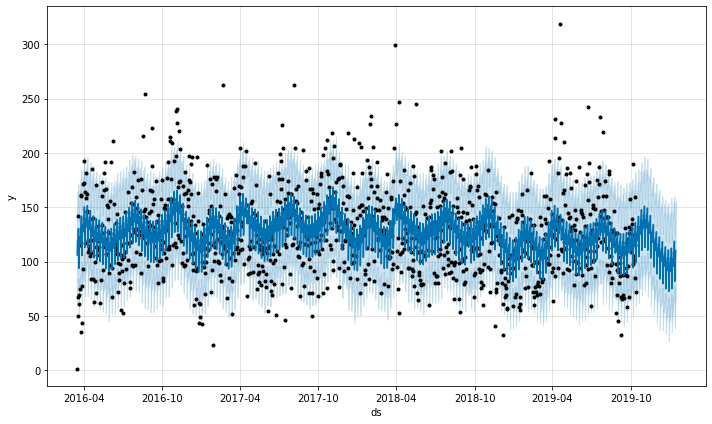

In [89]:
fig1 = prophet_basic.plot(forecast)

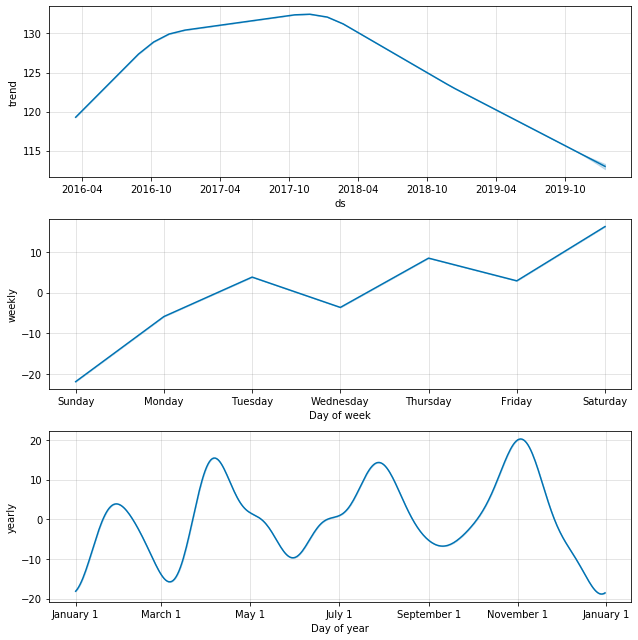

In [90]:
fig1 = prophet_basic.plot_components(forecast)

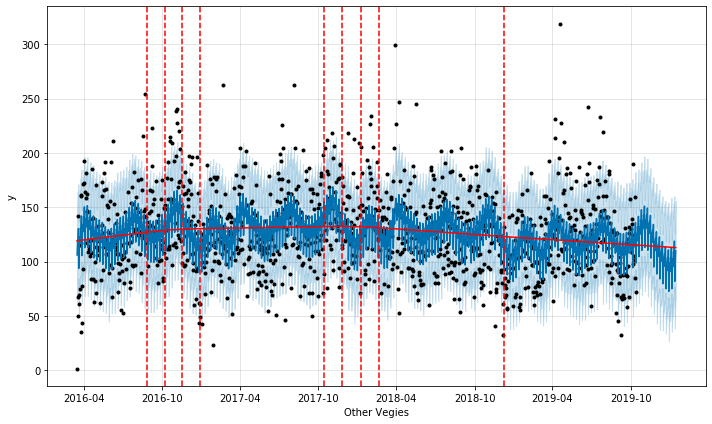

In [91]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Other Vegies');
plt.savefig('Other Vegies.png')

In [92]:
ov_checkpoint = prophet_basic.changepoints

### 7.) Onions

In [93]:
tsinput_ON = new_df_resetindex[new_df_resetindex.CATEGORY == 'Onions']
tsinput_ON = tsinput_ON[['TransDate','TOTAL_PRICESELL']]
tsinput_ON['TransDate'] = tsinput_ON['TransDate'].dt.date
tsinput_ON = tsinput_ON.rename(columns={'TransDate':'ds', 'TOTAL_PRICESELL':'y'})
tsinput_ON1 = pd.DataFrame(tsinput_ON.groupby('ds').sum()).reset_index()

##### Checking for accuracy

In [94]:
# Creating train and validation data to check for the error rate
train = tsinput_ON1[:1201]
validate = tsinput_ON1[1201:]
# Initializing the model
prophet_basic = Prophet()
prophet_basic.fit(train)
future = prophet_basic.make_future_dataframe(periods=80)
forecast = prophet_basic.predict(future)
# Calculating the RMSE and MAE
print('The root mean square error is:', np.sqrt(mean_squared_error(validate['y'],forecast['yhat'][-78:])))
print('The mean absolute error is:', mean_absolute_error(validate['y'], forecast['yhat'][-78:]))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The root mean square error is: 20.196061443053633
The mean absolute error is: 16.582887366149496


##### Predicting the values for the days after the validation data

In [95]:
prophet_basic = Prophet()
prophet_basic.fit(tsinput_ON1)
future= prophet_basic.make_future_dataframe(periods=93)
forecast=prophet_basic.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


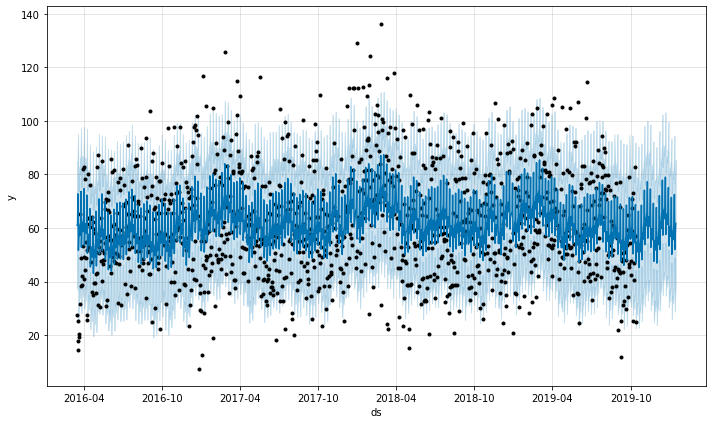

In [96]:
fig1 = prophet_basic.plot(forecast)

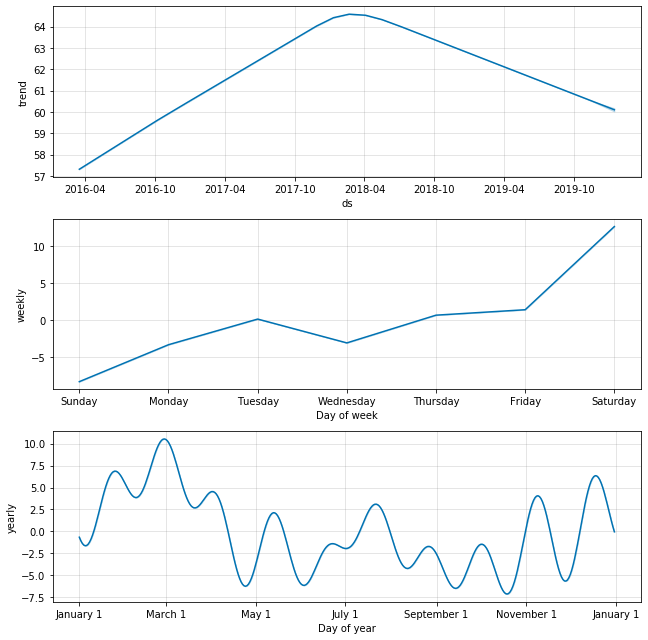

In [97]:
fig1 = prophet_basic.plot_components(forecast)

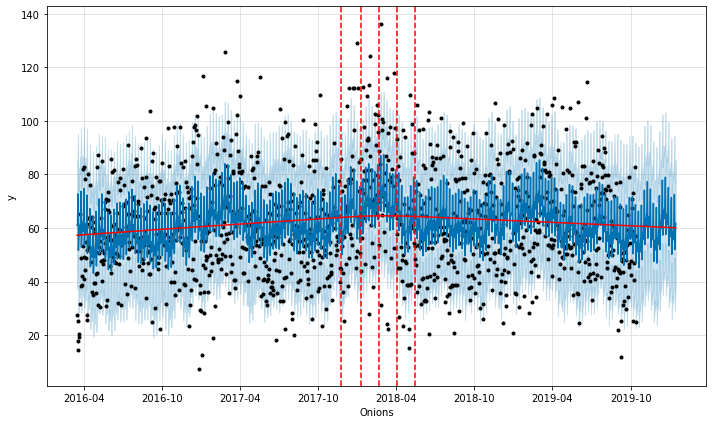

In [98]:
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)
plt.xlabel('Onions');
plt.savefig('Onions.png')

In [99]:
on_checkpoint = prophet_basic.changepoints

In [100]:
checkpoint_df = pd.DataFrame(overall_cp)
checkpoint_df['Banana'] = ba_checkpoint
checkpoint_df['Apple'] = ap_checkpoint
checkpoint_df['Potatoes'] = po_checkpoint
checkpoint_df['Citrus'] = ci_checkpoint
checkpoint_df['Tomatoes'] = to_checkpoint
checkpoint_df['Other Vegies'] = ov_checkpoint
checkpoint_df['Onions'] = on_checkpoint

In [101]:
checkpoint_df.rename(columns={'ds': 'Overall'}, inplace=True)

In [102]:
checkpoint_df

,Overall,Banana,Apple,Potatoes,Citrus,Tomatoes,Other Vegies,Onions
41,2016-04-26,2016-04-27,2016-04-27,2016-04-27,2016-04-26,2016-04-27,2016-04-26,2016-04-27
82,2016-06-06,2016-06-07,2016-06-07,2016-06-07,2016-06-06,2016-06-07,2016-06-06,2016-06-07
123,2016-07-17,2016-07-18,2016-07-18,2016-07-18,2016-07-17,2016-07-18,2016-07-17,2016-07-18
164,2016-08-27,2016-08-28,2016-08-28,2016-08-28,2016-08-27,2016-08-28,2016-08-27,2016-08-28
205,2016-10-07,NaT,NaT,NaT,2016-10-07,NaT,2016-10-07,NaT
246,2016-11-17,NaT,NaT,NaT,2016-11-17,NaT,2016-11-17,NaT
286,2016-12-28,2016-12-29,2016-12-29,2016-12-29,2016-12-28,2016-12-29,2016-12-28,2016-12-29
327,2017-02-07,2017-02-08,2017-02-08,2017-02-08,2017-02-07,2017-02-08,2017-02-07,2017-02-08
368,2017-03-20,2017-03-21,2017-03-21,2017-03-21,2017-03-20,2017-03-21,2017-03-20,2017-03-21
409,2017-05-02,2017-05-03,2017-05-03,2017-05-03,2017-05-02,2017-05-03,2017-05-02,2017-05-03


In [103]:
final_checkpoint = pd.DataFrame(checkpoint_df['Overall'])

In [104]:
final_checkpoint['Holidays'] = 0
final_checkpoint['Link for Reference'] = 0

In [105]:
final_checkpoint.iloc[0, 1] = 'Anzac Day'
final_checkpoint.iloc[0, 2] = 'https://www.timeanddate.com/holidays/australia/anzac-day'
final_checkpoint.iloc[1, 1] = 'Western Australia Day'
final_checkpoint.iloc[1, 2] = 'https://www.timeanddate.com/holidays/australia/foundation-day'
final_checkpoint.iloc[2, 1] = 'Weekend'
final_checkpoint.iloc[2, 2] = 'http://www.calendar-to-print.com/july-2016-calendar.html'
final_checkpoint.iloc[3, 1] = 'Weekend'
final_checkpoint.iloc[3, 2] = 'http://www.calendar-to-print.com/august-2016-calendar.html'
final_checkpoint.iloc[4, 1] = 'Norfolk Island Agricultural Show Day'
final_checkpoint.iloc[4, 2] = 'https://www.timeanddate.com/holidays/australia/agricultural-show-day'
final_checkpoint.iloc[5, 1] = 'First Sunday of Advent'
final_checkpoint.iloc[5, 2] = 'https://www.timeanddate.com/holidays/australia/first-day-advent'
final_checkpoint.iloc[6, 1] = "New Year's Eve"
final_checkpoint.iloc[6, 2] = 'https://www.timeanddate.com/holidays/australia/new-year-eve'
final_checkpoint.iloc[7, 1] = "Tu B'Shevat (Arbor Day)"
final_checkpoint.iloc[7, 2] = 'https://www.timeanddate.com/holidays/australia/tu-bshevat'
final_checkpoint.iloc[8, 1] = 'Harmony Day'
final_checkpoint.iloc[8, 2] = 'https://www.timeanddate.com/holidays/australia/harmony-day'
final_checkpoint.iloc[9, 1] = 'Yom HaAtzmaut'
final_checkpoint.iloc[9, 2] = 'https://www.timeanddate.com/holidays/australia/yom-haatzmaut'
final_checkpoint.iloc[10, 1] = "Queen's Birthday"
final_checkpoint.iloc[10, 2] = 'https://www.timeanddate.com/holidays/australia/queens-birthday'
final_checkpoint.iloc[11, 1] = 'Weekend'
final_checkpoint.iloc[11, 2] = 'http://www.calendar-to-print.com/july-2017-calendar.html'
final_checkpoint.iloc[12, 1] = 'Hari Raya Haji'
final_checkpoint.iloc[12, 2] = 'https://www.timeanddate.com/holidays/australia/hari-raya-haji'
final_checkpoint.iloc[13, 1] = 'Simchat Torah'
final_checkpoint.iloc[13, 2] = 'https://www.timeanddate.com/holidays/australia/simchat-torah'
final_checkpoint.iloc[14, 1] = 'Thanksgiving Day'
final_checkpoint.iloc[14, 2] = 'https://www.timeanddate.com/holidays/australia/thanksgiving-day'
final_checkpoint.iloc[15, 1] = 'Orthodox New Year'
final_checkpoint.iloc[15, 2] = 'https://www.timeanddate.com/holidays/australia/orthodox-new-year'
final_checkpoint.iloc[16, 1] = 'Chinese New Year'
final_checkpoint.iloc[16, 2] = 'https://www.timeanddate.com/holidays/australia/chinese-new-year'
final_checkpoint.iloc[17, 1] = 'Easter Tuesday'
final_checkpoint.iloc[17, 2] = 'https://www.timeanddate.com/holidays/australia/easter-tuesday'
final_checkpoint.iloc[18, 1] = 'Ramadan Start'
final_checkpoint.iloc[18, 2] = 'https://www.timeanddate.com/holidays/australia/ramadan-begins'
final_checkpoint.iloc[19, 1] = 'June Solstice'
final_checkpoint.iloc[19, 2] = 'https://www.timeanddate.com/calendar/june-solstice.html'
final_checkpoint.iloc[20, 1] = 'Northern Territory Picnic Day'
final_checkpoint.iloc[20, 2] = 'https://www.timeanddate.com/holidays/australia/picnic-day'
final_checkpoint.iloc[21, 1] = 'Yom Kippur'
final_checkpoint.iloc[21, 2] = 'https://www.timeanddate.com/holidays/australia/yom-kippur'
final_checkpoint.iloc[22, 1] = 'Halloween'
final_checkpoint.iloc[22, 2] = 'https://www.timeanddate.com/holidays/australia/halloween'
final_checkpoint.iloc[23, 1] = 'Last day of Hanukkah'
final_checkpoint.iloc[23, 2] = 'https://www.timeanddate.com/holidays/australia/last-day-chanukah'
final_checkpoint.iloc[24, 1] = 'Australia Day'
final_checkpoint.iloc[24, 2] = 'https://www.timeanddate.com/holidays/australia/australia-day'

In [106]:
final_checkpoint

,Overall,Holidays,Link for Reference
41,2016-04-26,Anzac Day,https://www.timeanddate.com/holidays/australia...
82,2016-06-06,Western Australia Day,https://www.timeanddate.com/holidays/australia...
123,2016-07-17,Weekend,http://www.calendar-to-print.com/july-2016-cal...
164,2016-08-27,Weekend,http://www.calendar-to-print.com/august-2016-c...
205,2016-10-07,Norfolk Island Agricultural Show Day,https://www.timeanddate.com/holidays/australia...
246,2016-11-17,First Sunday of Advent,https://www.timeanddate.com/holidays/australia...
286,2016-12-28,New Year's Eve,https://www.timeanddate.com/holidays/australia...
327,2017-02-07,Tu B'Shevat (Arbor Day),https://www.timeanddate.com/holidays/australia...
368,2017-03-20,Harmony Day,https://www.timeanddate.com/holidays/australia...
409,2017-05-02,Yom HaAtzmaut,https://www.timeanddate.com/holidays/australia...
